In [1]:
!pip install holidays
!pip install h3
!pip install geojson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 31.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import folium
from geojson import Feature, Point, FeatureCollection
import json
import matplotlib
import holidays
import h3
import seaborn as sns
import numpy as np
import datetime
#import random
import matplotlib.pyplot as plt
#import geopy.distance
%matplotlib inline
from IPython.display import display
#import branca
import branca.colormap as cm
#from folium import plugins
import warnings
import statistics
import math
import re
warnings.filterwarnings('ignore')

### MYCODE
# Add a progress bar to see how we are doing.
from tqdm import tqdm
# To measure time of operations.
from timeit import default_timer as tmr

In [3]:
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/dataMVG/MVG_Rad_Fahrten_2021'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Let's test the setup by simply checking if all paths are present
present = True
necessary_paths= []
files = os.listdir()
for path in necessary_paths:
    if path not in files:
        present = False
if not present:
    print("Can't find all required folders. You either installed the notebook in the wrong path or didn't upload the full exercise folder. You can check your paths in the file overview on the left.")
else:
    print('Google colab setup complete! Mounted folders:')
    print(files)


Mounted at /content/gdrive
Google colab setup complete! Mounted folders:
['MVG_Rad_Fahrten_2021.csv', '.ipynb_checkpoints', 'test_out.csv', 'BRP.ipynb']


This is the preprocessing - it is quiet time consuming so you might do it once and load a pickle file afterwards to save time. However, you might want to change parameters later (like cell size) or produce multiple pickle files with different parametrizations.

In [4]:
# read the csv file containing all the rides of 2021 and store it as a DataFrame
rides_df = pd.read_csv('MVG_Rad_Fahrten_2021.csv', sep=';', error_bad_lines=False)
# we want to get rid of empty spaces that exist in the column headers in the .csv. 
rides_df.columns = rides_df.columns.str.replace(' ', '')
rides_df['RETURN_STATION_NAME'] = rides_df['RETURN_STATION_NAME'].apply(lambda x: re.sub('\s+', '', x))
rides_df['RENTAL_STATION_NAME'] = rides_df['RENTAL_STATION_NAME'].apply(lambda x: re.sub('\s+', '', x))
# convert the format of the dates from string to Pandas Datetime
rides_df['STARTTIME'] = pd.to_datetime(rides_df['STARTTIME'])
rides_df['ENDTIME'] = pd.to_datetime(rides_df['ENDTIME'])
# calculate a duration column from start- and endtime of each trip
rides_df['duration'] = rides_df['ENDTIME'] - rides_df['STARTTIME']
# convert the duration column to seconds
rides_df['duration'] = rides_df['duration'].dt.total_seconds()

In [5]:
'''
# let's check if the day is weekend or weekday or holiday. This takes about 3 minutes.
# first, we need to get a list of holidays in Bavaria in 2021
h = holidays.country_holidays('DE', 'BY', years=[2021])
# unfortunately, we have to iterate through all columns - this is terribly slow.
for row in tqdm(rides_df.index):
    # check if date is a holiday
    if rides_df.loc[row, 'STARTTIME'].date() in h:
        rides_df.loc[row, 'is_holiday'] = 1
    else:
        rides_df.loc[row, 'is_holiday'] = 0
    # check if date is weekday or weekend
    if rides_df.loc[row, 'STARTTIME'].weekday() > 4:
        rides_df.loc[row, 'is_weekend'] = 1
    else:
        rides_df.loc[row, 'is_weekend'] = 0
'''

"\n# let's check if the day is weekend or weekday or holiday. This takes about 3 minutes.\n# first, we need to get a list of holidays in Bavaria in 2021\nh = holidays.country_holidays('DE', 'BY', years=[2021])\n# unfortunately, we have to iterate through all columns - this is terribly slow.\nfor row in tqdm(rides_df.index):\n    # check if date is a holiday\n    if rides_df.loc[row, 'STARTTIME'].date() in h:\n        rides_df.loc[row, 'is_holiday'] = 1\n    else:\n        rides_df.loc[row, 'is_holiday'] = 0\n    # check if date is weekday or weekend\n    if rides_df.loc[row, 'STARTTIME'].weekday() > 4:\n        rides_df.loc[row, 'is_weekend'] = 1\n    else:\n        rides_df.loc[row, 'is_weekend'] = 0\n"

In [6]:
#MYCODE: Change the type of iteration to make it faster.
#Transform df into a dictionary. Iterate over dictionary and reconstruct dataframe.

# let's check if the day is weekend or weekday or holiday.
# first, we need to get a list of holidays in Bavaria in 2021
h = holidays.country_holidays('DE', 'BY', years=[2021])

# Transfor dataframe into dictionary.
start = tmr()
rides_df_dict = rides_df.to_dict('records')
print ('Dataframe to Dict time is %5.3f s\n' % (tmr() - start))
assert len(rides_df_dict) == rides_df.shape[0], 'Error: Size of dictionary doesnt match dataframe!'

# Iterate through dictionary
for element in tqdm(range(len(rides_df_dict))):
    # check if date is a holiday
    if rides_df_dict[element]['STARTTIME'].date() in h:
        rides_df_dict[element]['is_holiday'] = 1
    else:
        rides_df_dict[element]['is_holiday'] = 0
    # check if date is weekday or weekend
    if rides_df_dict[element]['STARTTIME'].weekday() > 4:
       rides_df_dict[element]['is_weekend'] = 1
    else:
        rides_df_dict[element]['is_weekend'] = 0

# Reconstruct dataframe. Commented because we still have to work on the dataset.
#start = tmr()
#rides_df = pd.DataFrame.from_dict(rides_df_dict)
#print ('Dict to Dataframe time is %5.3f s\n' % (tmr() - start))


Dataframe to Dict time is 17.040 s



100%|██████████| 619573/619573 [00:03<00:00, 184736.07it/s]


In [7]:
'''
# now we finally add the H3 cell to each ride (start and end). H3 cells are enumerated with a 64-bit integer - this is basically a unique number for each cell. More on the concept and indexing here: https://h3geo.org/docs/core-library/h3Indexing
# first, we have to set the resolution (this is basically the size of the cells. 8 is the resolution i have shown you in the examples and I find it suitable to the problem - feel free to play around with it!).
# takes around 2.5 minutes
resolution = 4 # this is where you could change resolution!
# iterating over the DataFrame again - very slow again.
for row in(rides_df.index):
    rides_df.loc[row, 'h3_start'] = h3.geo_to_h3(lat=rides_df.loc[row, 'STARTLAT'], lng=rides_df.loc[row, 'STARTLON'], resolution=resolution)
    rides_df.loc[row, 'h3_end'] = h3.geo_to_h3(lat=rides_df.loc[row, 'ENDLAT'], lng=rides_df.loc[row, 'ENDLON'], resolution=resolution)

# we need coordinates of the centres of all cells
# retrieve all unique IDs where at least one ride has started or finished
hex_ids = list(rides_df["h3_start"].explode().unique()) + list(rides_df["h3_end"].explode().unique())


# store the coordinates in a dictionary for later purposes
cell_coords = {}
#retrieve values and store them
for id in hex_ids:
    cell_coords[id] = h3.h3_to_geo(id)
'''

'\n# now we finally add the H3 cell to each ride (start and end). H3 cells are enumerated with a 64-bit integer - this is basically a unique number for each cell. More on the concept and indexing here: https://h3geo.org/docs/core-library/h3Indexing\n# first, we have to set the resolution (this is basically the size of the cells. 8 is the resolution i have shown you in the examples and I find it suitable to the problem - feel free to play around with it!).\n# takes around 2.5 minutes\nresolution = 4 # this is where you could change resolution!\n# iterating over the DataFrame again - very slow again.\nfor row in(rides_df.index):\n    rides_df.loc[row, \'h3_start\'] = h3.geo_to_h3(lat=rides_df.loc[row, \'STARTLAT\'], lng=rides_df.loc[row, \'STARTLON\'], resolution=resolution)\n    rides_df.loc[row, \'h3_end\'] = h3.geo_to_h3(lat=rides_df.loc[row, \'ENDLAT\'], lng=rides_df.loc[row, \'ENDLON\'], resolution=resolution)\n\n# we need coordinates of the centres of all cells\n# retrieve all uniq

In [8]:
# MYCODE: Again, use dictionaries to make operation faster.
# now we finally add the H3 cell to each ride (start and end). H3 cells are enumerated with a 64-bit integer - this is basically a unique number for each cell. More on the concept and indexing here: https://h3geo.org/docs/core-library/h3Indexing
# first, we have to set the resolution (this is basically the size of the cells. 8 is the resolution i have shown you in the examples and I find it suitable to the problem - feel free to play around with it!).

resolution = 8 # this is where you could change resolution!

# iterating over the Dict again
for element in tqdm(range(len(rides_df_dict))):
    rides_df_dict[element]['h3_start'] = h3.geo_to_h3(lat = rides_df_dict[element]['STARTLAT'], lng = rides_df_dict[element]['STARTLON'], resolution = resolution)
    rides_df_dict[element]['h3_end'] = h3.geo_to_h3(lat = rides_df_dict[element]['ENDLAT'], lng = rides_df_dict[element]['ENDLON'], resolution = resolution)

# This is unnecessary here, but with it "hex_ids" is easier to compute and I don't have to think more... 
# Reconstruct dataframe. Commented because we still have to work on the dataset.
start = tmr()
rides_df = pd.DataFrame.from_dict(rides_df_dict)
print ('Dict to Dataframe time is %5.3f s\n' % (tmr() - start))

# we need coordinates of the centres of all cells
# retrieve all unique IDs where at least one ride has started or finished
hex_ids = list(rides_df["h3_start"].explode().unique()) + list(rides_df["h3_end"].explode().unique())


# store the coordinates in a dictionary for later purposes
cell_coords = {}
#retrieve values and store them
for id in hex_ids:
    cell_coords[id] = h3.h3_to_geo(id)

100%|██████████| 619573/619573 [00:04<00:00, 144479.38it/s]


Dict to Dataframe time is 2.037 s



now, we have all the information we need to calculate disbalances in our system. What we want (for now) is an average surplus/shortage of bikes per cell per weekday.

In [9]:
start = tmr()
# this is the slowest operation - takes ~ 15 min
# first, we filter out the weekends and holidays
# wd is short for working days
rides_wd = rides_df[(rides_df['is_weekend']==0) & (rides_df['is_holiday']==0)]
# we add a date column (without time), will be needed for filtering later
rides_wd['STARTDATE'] = rides_wd['STARTTIME'].apply(lambda x: x.date())
rides_wd['ENDDATE'] = rides_wd['ENDTIME'].apply(lambda x: x.date())
# we dp also need the IDs of the cells as a list to filter 
hex_ids = list(rides_wd["h3_start"].explode().unique()) + list(rides_wd["h3_end"].explode().unique())

# we will create a dictionary where every cell gets a value (the average, median & max disbalance over 24h - so we can decide what's interesting)
cell_disbalances_avg = {}
cell_disbalances_median = {}
cell_disbalances_max = {}
cell_disbalances_round = {}
cell_disbalances_round_up = {}

# now let's start to count...
for hex_id in tqdm(hex_ids):
    # first, we filter the DataFrame to only contain the currently relevant cell
    tmp_df = rides_wd[(rides_wd['h3_start']==hex_id) | (rides_wd['h3_end']==hex_id)]
    # now we need a list of all days so we can filter by that
    dates_tmp = set(list(tmp_df["STARTDATE"].explode().unique()) + list(tmp_df["ENDDATE"].explode().unique()))
    # we can now create list with the respective values for each date
    disbalances_tmp = []
    for date in dates_tmp:
        disbalances_tmp.append(len(tmp_df[(tmp_df['h3_end']==hex_id) & (tmp_df['ENDDATE']==date)]) - len(tmp_df[(tmp_df['h3_start']==hex_id) & (tmp_df['STARTDATE']==date)]))
    # now we have to build the average:
    cell_disbalances_avg[hex_id] = statistics.mean(disbalances_tmp)
    cell_disbalances_median[hex_id] = statistics.median(disbalances_tmp)
    cell_disbalances_max[hex_id] = max(disbalances_tmp)
    cell_disbalances_round[hex_id] = round(cell_disbalances_avg[hex_id])
    cell_disbalances_round_up[hex_id] = math.ceil(cell_disbalances_avg[hex_id]) if cell_disbalances_avg[hex_id]>0 else math.floor(cell_disbalances_avg[hex_id])

    #Test: Copy cell disbalances round up to compare with method #2
    cache_cell_disbalances_round_up = cell_disbalances_round_up.copy()

print('\nRun time of method #1: %5.3f s' % (tmr() - start))

100%|██████████| 1491/1491 [06:34<00:00,  3.78it/s]


Run time of method #1: 397.878 s


In [10]:
#MYCODE: Method #2 that uses dicts instead of dataframe.
#CAUTION: The result produced by this code does not match the one given. WHY?
# dates_tmp is the same in both methods
start = tmr()
# first, we filter out the weekends and holidays
# wd is short for working days
rides_wd = rides_df[(rides_df['is_weekend']==0) & (rides_df['is_holiday']==0)]
# we add a date column (without time), will be needed for filtering later
rides_wd['STARTDATE'] = rides_wd['STARTTIME'].apply(lambda x: x.date())
rides_wd['ENDDATE'] = rides_wd['ENDTIME'].apply(lambda x: x.date())
# we dp also need the IDs of the cells as a list to filter 
hex_ids = list(rides_wd["h3_start"].explode().unique()) + list(rides_wd["h3_end"].explode().unique())

# we will create a dictionary where every cell gets a value (the average, median & max disbalance over 24h - so we can decide what's interesting)
cell_disbalances_avg = {}
cell_disbalances_median = {}
cell_disbalances_max = {}
cell_disbalances_round = {}
cell_disbalances_round_up = {}

# now let's start to count...
# First transform to dictionary to speed up computation.
rides_wd_dict = rides_wd.to_dict('resources')

for hex_id in tqdm(hex_ids):
    # first, we filter the DataFrame to only contain the currently relevant cell
    # MYCODE: we separate into rides starting at hex_id and rides ending in hex_id to speed up computation later
    tmp_wd_dict_start = [] #list of dates st. a ride starts at hex_id
    tmp_wd_dict_end = [] #list of dates st. a ride ends at hex_id
    for element in range(len(rides_wd_dict)):
      if rides_wd_dict[element]['h3_start'] == hex_id:
        tmp_wd_dict_start.append(rides_wd_dict[element]['STARTDATE'])
        
      if rides_wd_dict[element]['h3_end'] == hex_id:
        tmp_wd_dict_end.append(rides_wd_dict[element]['ENDDATE'])

    disbalances_tmp = {}
    for element in tmp_wd_dict_start:
        disbalances_tmp[element] = disbalances_tmp.setdefault(element, 0) - 1

    for element in tmp_wd_dict_end:
        disbalances_tmp[element] = disbalances_tmp.setdefault(element, 0) + 1

    # now we have to build the average:
    cell_disbalances_avg[hex_id] = statistics.mean(disbalances_tmp.values())
    cell_disbalances_median[hex_id] = statistics.median(disbalances_tmp.values())
    cell_disbalances_max[hex_id] = max(disbalances_tmp.values())
    cell_disbalances_round[hex_id] = round(cell_disbalances_avg[hex_id])
    cell_disbalances_round_up[hex_id] = math.ceil(cell_disbalances_avg[hex_id]) if cell_disbalances_avg[hex_id]>0 else math.floor(cell_disbalances_avg[hex_id])

print ('\nRun time method #2 is %5.3f s' % (tmr() - start))


100%|██████████| 1491/1491 [03:08<00:00,  7.92it/s]


Run time method #2 is 204.566 s


In [50]:
# MYCODE TEST. Check that the round up disbalances are the same for both methods.
################################################################################
# TODO
################################################################################
# Check why there are some disagreements in the value lists. It looks like only
# there are very little disagreements, so it is possible that this disagreement
# Comes from the fact that there are outliers in the data.
################################################################################

tolerance = 1e-2
vals = np.fromiter(cell_disbalances_round_up.values(), dtype=float)
cache_vals = np.fromiter(cache_cell_disbalances_round_up.values(), dtype=float)
assert np.count_nonzero( np.subtract(vals, cache_vals)) <= tolerance * len(vals),  print('The cell disbalances in method #2 dont agree with method #1 dont agree with tolerance %5.3e' %tolerance)

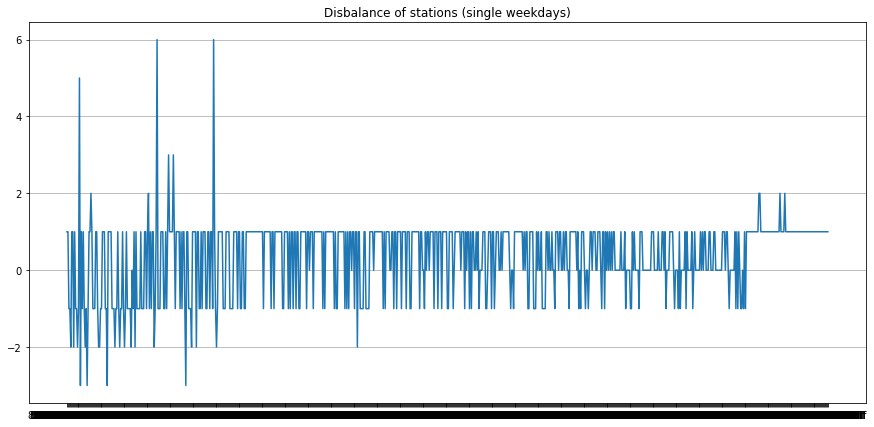

In [51]:
#we have a lot of data - to get an idea we can plot it. Feel free to build own (better) vizualizations!
x, y = zip(*cell_disbalances_round_up.items())
plt.plot(x,y)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 7)
plt.grid(visible=True, axis='y')
plt.title("Disbalance of stations (single weekdays)")
plt.show()

In [ ]:
nr_bins = 50
bw_adjust = 4
sns.histplot(data=cell_disbalances_round_up.items(), kde=True, kde_kws={'bw_adjust':bw_adjust}, bins=nr_bins, label="Weekday")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 7)
plt.show()

We can also look at complete working weeks - this oviously leads to higher numbers.

In [ ]:
# to consider weeks, we need to add the week number
rides_wd['STARTWEEK'] = rides_wd['STARTTIME'].apply(lambda x: x.date().strftime("%V"))
rides_wd['ENDWEEK'] = rides_wd['ENDTIME'].apply(lambda x: x.date().strftime("%V"))
# we dp also need the IDs of the cells as a list to filter 
hex_ids = list(rides_wd["h3_start"].explode().unique()) + list(rides_wd["h3_end"].explode().unique())
# we will create a dictionary where every cell gets a value (the average, median & max disbalance over 24h)
cell_disbalances_avg_week = {}
cell_disbalances_median_week = {}
cell_disbalances_max_week = {}
cell_disbalances_round_week = {}
cell_disbalances_round_up_week = {}

# now let's start to count...
for hex_id in tqdm(hex_ids):
    
    # first, we filter the DataFrame to only contain the currently relevant cell
    tmp_df = rides_wd[(rides_wd['h3_start']==hex_id) | (rides_wd['h3_end']==hex_id)]
    
    # now we need a list of all days so we can filter by that
    dates_tmp = set(list(tmp_df["STARTDATE"].explode().unique()) + list(tmp_df["ENDDATE"].explode().unique()))
    weeks_tmp = set([x.strftime("%V") for x in dates_tmp])
    
    # we can now create list with the respective values for each date
    disbalances_tmp = []
    for week in weeks_tmp:
        disbalances_tmp.append(len(tmp_df[(tmp_df['h3_end']==hex_id) & (tmp_df['ENDWEEK']==week)]) - len(tmp_df[(tmp_df['h3_start']==hex_id) & (tmp_df['STARTWEEK']==week)]))
    
    # now we have to build the average:
    cell_disbalances_avg_week[hex_id] = statistics.mean(disbalances_tmp)
    cell_disbalances_median_week[hex_id] = statistics.median(disbalances_tmp)
    cell_disbalances_max_week[hex_id] = max(disbalances_tmp)
    cell_disbalances_round_week[hex_id] = round(cell_disbalances_avg_week[hex_id])
    cell_disbalances_round_up_week[hex_id] = math.ceil(cell_disbalances_avg_week[hex_id]) if cell_disbalances_avg_week[hex_id]>0 else math.floor(cell_disbalances_avg_week[hex_id])

In [ ]:
#we have a lot of data - to get an idea we can plot it. Feel free to build better vizualizations!
x, y = zip(*cell_disbalances_round_week.items())
plt.plot(x,y)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
plt.grid(visible=True, axis='y')
plt.title("Disbalance of stations (Monday-Friday)")
plt.show()

In [ ]:
nr_bins = 50
bw_adjust = 4
sns.histplot(data=cell_disbalances_round_week.items(), kde=True, kde_kws={'bw_adjust':bw_adjust}, bins=nr_bins, label="Weekday")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
print(len(hex_ids))


Let's have a look on the map! Unfortunately, we therefore need some helper functions. This involves converting our hex cells to linestrings that can be plottet, defining colormaps that match the min/max values and of course creating a map.

In [ ]:
# helper functions for hexbin plotting
def hexagons_dataframe_to_geojson(df_hex, file_output=None, column_name="value"):
    """
    Produce the GeoJSON for a dataframe, constructing the geometry from the "hex_id" column
    and with a property matching the one in column_name
    """
    list_features = []

    for i, row in df_hex.iterrows():
        geometry_for_row = {"type": "Polygon",
                            "coordinates": [h3.h3_to_geo_boundary(h=row["id"], geo_json=True)]}
        feature = Feature(geometry=geometry_for_row, id=str(row["id"]), properties={column_name: int(row[column_name])})
        list_features.append(feature)


    feat_collection = FeatureCollection(list_features)
    geojson_result = json.dumps(feat_collection)
    return geojson_result


def get_color(custom_cm, val, vmin, vmax):
    return matplotlib.colors.to_hex(custom_cm((val - vmin) / (vmax - vmin)))


def choropleth_map(df_aggreg, column_name="value", border_color='black', fill_opacity=0.5, color_map_name="Blues",
                   initial_map=None):
    """
    Creates choropleth maps given the aggregated data. initial_map can be an existing map to draw on top of.
    """
    # colormap
    min_value = df_aggreg[column_name].min()
    max_value = df_aggreg[column_name].max()
    mean_value = df_aggreg[column_name].mean()
    print(f"Colour column min value {min_value}, max value {max_value}, mean value {mean_value}")
    print(f"Hexagon cell count: {df_aggreg['id'].nunique()}")

    # the name of the layer just needs to be unique, put something silly there for now:
    name_layer = "Choropleth " + str(df_aggreg)

    # if no map exists, we build one already zoomed into Munich for our case. 
    if initial_map is None:
        initial_map = folium.Map(location=[48.144975, 11.556093], zoom_start=12, tiles="stamentoner")

    # create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex=df_aggreg, column_name=column_name)

    # many more at https://matplotlib.org/stable/tutorials/colors/colormaps.html to choose from!
    #custom_cm = matplotlib.cm.get_cmap(color_map_name)
    custom_cm_ff = cm.LinearColormap(colors=['red', 'white', 'green'], index=[min_value, 0, max_value], vmin=min_value,vmax=max_value)
    custom_cm_ff.caption = 'Delta between returns and rentals'
    custom_cm_ff.add_to(initial_map)

    # now we put the contents (colored bins) on the base map using folium
    folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            #'fillColor': get_color(custom_cm, feature['properties'][column_name], vmin=min_value, vmax=max_value),
            'fillColor': custom_cm_ff(feature['properties'][column_name]),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity, 
            'popup':feature['properties'][column_name]
        },
        name=name_layer
    ).add_to(initial_map)
    

    

    return initial_map

In [ ]:
# we also need a dataframe with a specific shape for the plotting function (and we need to save it for your further calcuations ;). there hast to be a column with the IDs of the cells and values. So we build that DF out of the dictionary

def get_x(h3_id):
    # returns the x coordinate of a h3 cell
    return (cell_coords[h3_id][0])
def get_y(h3_id):
    # returns the y coordinate of a h3 cell
    return (cell_coords[h3_id][1])

# this is the DataFrame we will save as csv (ID, delta, coords)- if you change the Dataframe from which we take the items, you can produce another csv.
out_df = pd.DataFrame(cell_disbalances_round_up_week.items(), columns=['id', 'delta'])
# add the x coordinate
out_df['x_coord'] = out_df['id'].apply(lambda x: get_x(x))
# add the y coordinate
out_df['y_coord'] = out_df['id'].apply(lambda x: get_y(x))

# save as csv
out_df.to_csv('test_out.csv')
#display the top rows of DF
out_df.head()


In [ ]:
# now let's finally take a look at the map! First, we have to build it using the previoously defined helper functions.
m_d_wd = choropleth_map(df_aggreg = out_df, column_name='delta', color_map_name = "viridis", fill_opacity=0.7)
# display it
m_d_wd